# Gaussian volume denoising (Corbel)

In [1]:
use_OpenCV = True
local_debug = True

In [2]:
import logging
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
#from ipywidgets import *
#import cv2
import time
#import kernels
#import skimage
#from skimage import io as skimage_io

In [3]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [4]:
if local_debug:
    !ln -sf ../../information_theory/src/information_theory/ .
else:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
import information_theory  # pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [5]:
if use_OpenCV:
    from denoising.volume.gaussian import Monochrome_Denoising as gaussian_denoising

In [6]:
import skimage.io

In [7]:
from collections import namedtuple
Args = namedtuple("args", ["input", "output"])
args = Args("Corbel2301_block2_June2019_crop_ali_crop.mrc", "denoised")

In [8]:
import mrcfile
#vol_name = "Corbel2301_block2_June2019_crop_june2024_ali_crop.mrc"
#vol_name="epfl1_subset1_float.mrc"
#vol_name="small_vol.mrc"
with mrcfile.open(args.input, permissive=True) as mrc:
    noisy = mrc.data

In [9]:
Z_dim = noisy.shape[0]
Z2 = Z_dim//2

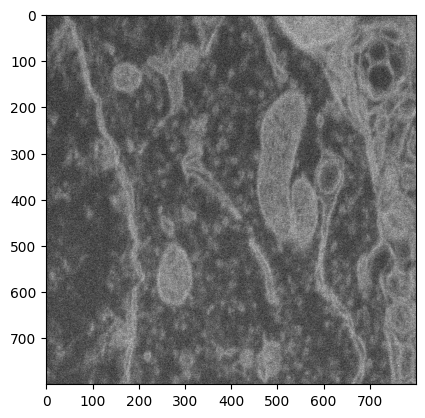

In [10]:
plt.imshow(noisy[Z2], cmap="gray")

In [23]:
def get_gaussian_kernel(sigma=1):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

sigma = np.array([0.5, 0.5, 0.5])
kernel = [None]*3
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
kernel[2] = get_gaussian_kernel(sigma[2])

In [24]:
denoiser = gaussian_denoising(logger)
denoised = denoiser.filter(noisy, kernel)

[gaussian.py:99 filter()] mean=97.64163970947266
[gaussian.py:101 filter()] filtered along Z
[gaussian.py:103 filter()] filtered along Y
[gaussian.py:105 filter()] filtered along X


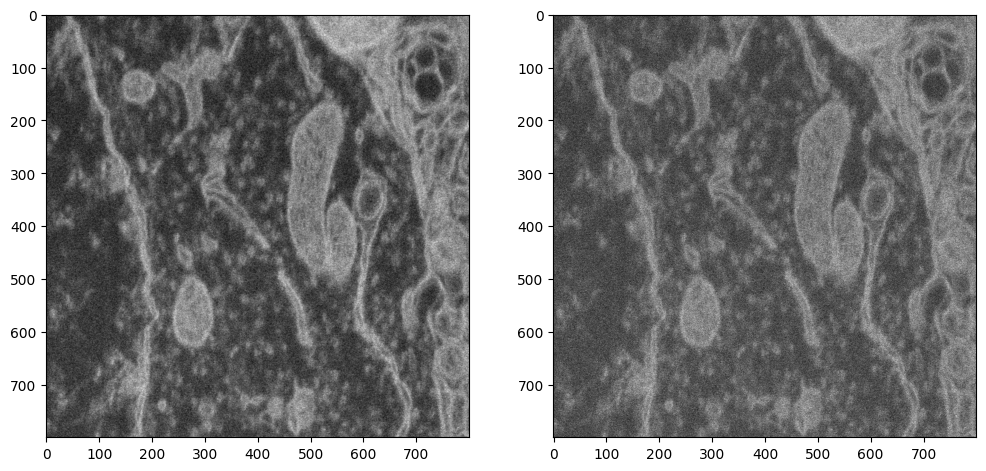

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(denoised[Z2], cmap="gray")
axes[1].imshow(noisy[Z2], cmap="gray")
plt.show()

In [26]:
with mrcfile.new(f"{args.input}_{sigma[0]}.mrc", overwrite=True) as mrc:
            mrc.set_data(denoised.astype(np.float32))
            mrc.data

In [15]:
!pip install "self_fourier_shell_correlation @ git+https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation"
from self_fourier_shell_correlation import fsc_utils as fsc

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation to /tmp/pip-install-zcmqw177/self-fourier-shell-correlation_4502330dab3c4274940e42274b42245a
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation /tmp/pip-install-zcmqw177/self-fourier-shell-correlation_4502330dab3c4274940e42274b42245a
  Resolved https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation to commit 2882c02d261f7011a60c8457c2c2b1d15d326d11
  Installing build dependencies ... \^C
anceled
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [16]:
ROI_noisy = noisy[100:300, 150:350, 50:250]

In [17]:
def get_FSC_curve(volume):
    y1 = volume
    s1 = y1[:, :, ::2]
    s2 = y1[:, :, 1::2]
    S2 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s2)), 0.5, 0, 0)
    s2_shift = np.fft.ifftn(np.fft.ifftshift(S2)).real

    s3 = y1[:, ::2, :]
    s4 = y1[:, 1::2, :]
    S4 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s4)), 0, 0.5, 0)
    s4_shift = np.fft.ifftn(np.fft.ifftshift(S4)).real

    s5 = y1[::2, :, :]
    s6 = y1[1::2, :, :]
    S6 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s6)), 0, 0, 0.5)
    s6_shift = np.fft.ifftn(np.fft.ifftshift(S6)).real

    r = volume.shape[0]//2

    c1 = fsc.two_volume_fsc(s1, s2_shift, r)
    c2 = fsc.two_volume_fsc(s3, s4_shift, r)
    c3 = fsc.two_volume_fsc(s5, s6_shift, r)

    c_avg = np.mean([c1, c2, c3], axis=0)

    freq = fsc.get_radial_spatial_frequencies(s1, 1)

    return freq, c_avg

In [18]:
freq, c_avg_noisy = get_FSC_curve(ROI_noisy)

ValueError: Invalid number of FFT data points (0) specified.

In [ ]:
plt.plot(freq, c_avg_noisy)

In [ ]:
ROI_noisy = noisy[100:300, 150:350, 50:250]

In [ ]:
sigma = np.array([12.0, 12.0, 12.0])
kernel = [None]*3
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
kernel[2] = get_gaussian_kernel(sigma[2])

In [ ]:
denoiser = gaussian_denoising(logger)
denoised = denoiser.filter(ROI_noisy, kernel)

In [ ]:
freq, c_avg_noisy = get_FSC_curve(ROI_noisy)

In [ ]:
freq, c_avg_denoised = get_FSC_curve(denoised)

In [ ]:
plt.plot(freq, c_avg_noisy, label="Noisy")
plt.plot(freq, c_avg_denoised, label="Denoised")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(denoised[denoised.shape[0]//2], cmap="gray")
axes[1].imshow(ROI_noisy[ROI_noisy.shape[0]//2], cmap="gray")
plt.show()

In [ ]:
np.min(c_avg_denoised)

In [ ]:
freq[np.argmin(c_avg_denoised)]